# Recent supernova

Select only fast rising recent supernova, discard candidates too close to the ecliptic or the MW plane, or which have a very large galactic extinction. Also discard candidates which have a high bogus probability (own, or rb or drb)

### Load libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from IPython.core.display import display, HTML

In [42]:
from matplotlib.cm import viridis

ALeRCE client

In [43]:
#!pip install alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

Use pyephem https://pypi.org/project/pyephem/

In [44]:
#!pip install pyephem
import ephem

Install psycopg2 https://github.com/psycopg/psycopg2

In [45]:
#!pip install psycopg2-binary
import psycopg2

In [46]:
import requests

### Get credentials (in github repository)

In [47]:
import json
credentials_file = "../alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [48]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [49]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
9,asassn
18,class
10,crtsnorth
12,crtssouth
4,detections
23,early_classification_v2
16,features
22,features_v2
2,features_v3
24,ingestion_timestamp


### For each table, show column names and column types

In [50]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [51]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

### Query objects which appeared during the last xx days, which are classified as supernova by the early classifier with a probability greater than 0.5

In [52]:
mjd_last = Time(datetime.utcnow(), scale='utc').mjd - 30

query='''
select objects.oid, objects.meanra, objects.meandec, objects.firstmjd,
objects.nobs, objects.classearly, objects.pclassearly

from objects

where objects.firstMJD > %s
and objects.classearly=%i
and objects.pclassearly>0.5
''' % (mjd_last, classmapper["SN"])

sn = pd.read_sql_query(query, conn)
sn.set_index('oid', inplace=True)
print(sn.shape)
sn.head()

(437, 6)


,meanra,meandec,firstmjd,nobs,classearly,pclassearly
oid,,,,,,
ZTF20aarykbi,97.697554,33.960916,58909.202662,1,19,0.547014
ZTF20aaryowz,115.297701,16.626503,58909.211458,1,19,0.531529
ZTF20aahzlwq,123.589925,25.333049,58909.212801,1,19,0.534864
ZTF20aaryvjo,146.037574,46.279519,58909.247650,1,19,0.501329
ZTF20aaryvhi,142.367833,48.970983,58909.247650,15,19,0.537257


### Add early classifier probabilities to sn dataframe

In [53]:
query='''
select oid, sn_prob, vs_prob, agn_prob, asteroid_prob, bogus_prob

from stamp_classification

where oid in (%s)
''' % (",".join(["'%s'" % oid for oid in sn.index]))

early = pd.read_sql_query(query, conn)
early.set_index('oid', inplace=True)
sn = pd.concat([sn, early], axis=1, sort=False)
sn.head()

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob
ZTF20aarykbi,97.697554,33.960916,58909.202662,1,19,0.547014,0.547014,0.092383,0.086140,0.097269,0.177194
ZTF20aaryowz,115.297701,16.626503,58909.211458,1,19,0.531529,0.531529,0.086949,0.087870,0.188337,0.105315
ZTF20aahzlwq,123.589925,25.333049,58909.212801,1,19,0.534864,0.534864,0.143750,0.115540,0.120137,0.085710
ZTF20aaryvjo,146.037574,46.279519,58909.247650,1,19,0.501329,0.501329,0.098533,0.083281,0.205793,0.111064
ZTF20aaryvhi,142.367833,48.970983,58909.247650,15,19,0.537257,0.537257,0.102504,0.098679,0.117319,0.144241


### Refine search, get first detections if not close to a star and not a bogus according to rb

In [54]:
query='''
select detections.oid, detections.candid,
detections.sgscore1, detections.distpsnr1, detections.rb,
detections.fid, detections.mjd, detections.magpsf, detections.sigmapsf,
detections.has_stamps

from detections

where (detections.sgscore1 < 0.5 or detections.distpsnr1 > 1)
and detections.rb > 0.5
and detections.oid in (%s)
''' % (",".join(["'%s'" % oid for oid in sn.index]))

detections = pd.read_sql_query(query, conn)
detections.set_index('oid', inplace=True)
detections.head()

,candid,sgscore1,distpsnr1,rb,fid,mjd,magpsf,sigmapsf,has_stamps
oid,,,,,,,,,
ZTF20aaryvhi,1155327494515015003,0.020792,4.453146,0.925714,2,58909.327500,19.494995,0.117289,True
ZTF20aarzzta,1155320820115015010,0.000000,8.399424,0.644286,2,58909.320822,20.057854,0.171262,True
ZTF20aabqfpl,1155327043515015012,0.001250,0.523434,0.504286,2,58909.327049,20.121517,0.198376,True
ZTF20aasabmb,1155329420515015003,0.049625,0.942708,0.777143,2,58909.329421,20.162455,0.185032,True
ZTF20aasbuns,1157393903715015009,0.009958,1.649189,0.780000,1,58911.393901,19.488697,0.207959,True


### Get non detections after previous filtering

In [55]:
query='''
select non_detections.oid, 
non_detections.mjd, non_detections.diffmaglim, non_detections.fid

from non_detections

where non_detections.oid in (%s)
''' % (",".join(["'%s'" % oid for oid in detections.index.unique()]))

non_detections = pd.read_sql_query(query, conn)
non_detections.set_index('oid', inplace=True)
non_detections.head()

,mjd,diffmaglim,fid
oid,,,
ZTF20aaryvhi,58879.264062,19.772800,1
ZTF20aaryvhi,58879.305775,19.812099,2
ZTF20aaryvhi,58879.326655,19.833599,2
ZTF20aaryvhi,58880.256979,20.204300,1
ZTF20aaryvhi,58880.266366,20.344999,1


### Compute dm/dt

In [56]:
def do_dmdt(oid):
    dmdts = []
    dets = detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        dets = dets.to_frame().transpose()
    except:
        True 
    non_dets = non_detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        non_dets = non_dets.to_frame().transpose()
    except:
        True 
    for fid in sorted(dets.fid.unique()):
        if fid == 1:
            fid_str = "g"
        elif fid == 2:
            fid_str = "r"
        else:
            continue
        mask_det = (dets.fid == fid)
        idx_1st_det = dets.loc[mask_det].mjd.astype(float).idxmin()
        mask_non_det = (non_dets.mjd < float(sn.loc[oid].firstmjd)) & (non_dets.fid == fid)
        if mask_non_det.sum() >= 1: # filter must be in both dets and non_dets
            dm = np.array(dets.loc[idx_1st_det].magpsf - non_dets.loc[mask_non_det].diffmaglim)
            dm_error = np.array(dets.loc[idx_1st_det].magpsf + dets.loc[idx_1st_det].sigmapsf - non_dets.loc[mask_non_det].diffmaglim)
            dt = np.array(dets.loc[idx_1st_det].mjd - non_dets.loc[mask_non_det].mjd)
            dmdt = dm/dt
            dmdt_error = dm_error/dt
            idx_dmdt = np.argmin(dmdt_error) #dmdt = (dm/dt).min()                                                                                                                                         
            dmdt_min = dmdt[idx_dmdt]
            dmdt_error_min = dmdt_error[idx_dmdt]
            newdf = pd.DataFrame(data = {"dmdt_min": [dmdt_min], "dmdt_error": [dmdt_error_min - dmdt_min], \
                                         "dmdt_comp": [dmdt_error_min], 'dt': [dt[idx_dmdt]], 'fid': int(fid), \
                                         'Flag': [dt[idx_dmdt] < 0.5]}, index = [oid])
            dmdts.append(newdf)            

    if dmdts == []:
        return None
    else:
        return pd.concat(dmdts)

In [57]:
oids_nd = non_detections.index.unique()
dmdts = []
for oid in oids_nd:
    dmdt = do_dmdt(oid)
    if dmdt is None:
        continue
    else:
        dmdts.append(dmdt)
dmdts = pd.concat(dmdts)
dmdts.head()

,dmdt_min,dmdt_error,dmdt_comp,dt,fid,Flag
ZTF20aaryvhi,-0.347419,0.038558,-0.308861,3.041875,1,False
ZTF20aaryvhi,-0.191216,0.019206,-0.172009,6.106748,2,False
ZTF20aarzzta,-0.094981,0.028891,-0.066091,5.927951,2,False
ZTF20aabqfpl,-16.778452,13.980187,-2.798265,0.014190,2,True
ZTF20aasabmb,-0.067477,0.030272,-0.037205,6.112396,2,False


### Selection criterior: dmdt_min - dmdt_error < threshold (e.g. -0.5 mag / day), add warning if dt < 0.5

In [58]:
# select objects that rise faster than this value in some band
threshold = -0.5 # mag / day
oids_dmdt = dmdts.loc[dmdts.dmdt_comp < threshold].index.unique().tolist()
print(len(oids_dmdt))
print(oids_dmdt)

19
['ZTF20aabqfpl', 'ZTF20aascvvo', 'ZTF20aascwar', 'ZTF20aasffjj', 'ZTF20aasijew', 'ZTF20aasiuxr', 'ZTF20aasippu', 'ZTF20aasmgqk', 'ZTF20aasotla', 'ZTF20aaspdtp', 'ZTF20aaspgrq', 'ZTF20aaswrvk', 'ZTF20aasxavi', 'ZTF20aasxmng', 'ZTF18aanmump', 'ZTF20aatckgn', 'ZTF20aasosot', 'ZTF20aasxfkz', 'ZTF20aatckft']


### get avros of final list and get drb field for additional filter

In [59]:
drb = {}
for oid in oids_dmdt:
    print(oid)
    
    # get candid of first stamp
    candid = detections.loc[detections.has_stamps].loc[oid].candid.min()

    params = {"oid": oid, "candid": candid}
    url = "http://avro.alerce.online"
    r = requests.get(url = "%s/get_avro_info" % url, params = params)
    response = r.json()
    
    drb_val = response["candidate"]["drb"]
    if drb_val >= 0.5:
        drb[oid] = drb_val

sn["drb"] = pd.Series(data = list(drb.values()), index = list(drb.keys()))

ZTF20aabqfpl
ZTF20aascvvo
ZTF20aascwar
ZTF20aasffjj
ZTF20aasijew
ZTF20aasiuxr
ZTF20aasippu
ZTF20aasmgqk
ZTF20aasotla
ZTF20aaspdtp
ZTF20aaspgrq
ZTF20aaswrvk
ZTF20aasxavi
ZTF20aasxmng
ZTF18aanmump
ZTF20aatckgn
ZTF20aasosot
ZTF20aasxfkz
ZTF20aatckft


### Do oid list including drb

In [60]:
oids = list(drb.keys())
print(len(oids))
print(oids)

14
['ZTF20aabqfpl', 'ZTF20aascvvo', 'ZTF20aascwar', 'ZTF20aasffjj', 'ZTF20aasijew', 'ZTF20aasiuxr', 'ZTF20aasippu', 'ZTF20aasotla', 'ZTF20aasxavi', 'ZTF20aasxmng', 'ZTF18aanmump', 'ZTF20aatckgn', 'ZTF20aasosot', 'ZTF20aatckft']


# Show summary of all tables

In [61]:
sn.loc[oids]

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb
ZTF20aabqfpl,153.042646,55.553158,58909.327049,1,19,0.527008,0.527008,0.114736,0.126715,0.120602,0.110940,0.999727
ZTF20aascvvo,234.452145,38.146446,58911.514005,7,19,0.610035,0.610035,0.089948,0.095542,0.110150,0.094325,0.999999
ZTF20aascwar,239.603347,32.968878,58911.516401,9,19,0.670682,0.670682,0.086304,0.085601,0.080107,0.077306,0.999999
ZTF20aasffjj,169.985489,20.585445,58912.271065,1,19,0.589211,0.589211,0.087358,0.087941,0.102698,0.132792,0.999886
ZTF20aasijew,216.905404,69.686412,58912.457940,8,19,0.654863,0.654863,0.088518,0.084036,0.103524,0.069060,1.000000
ZTF20aasiuxr,248.327037,0.897468,58912.482581,6,19,0.508704,0.508704,0.086668,0.080974,0.228977,0.094677,0.999913
ZTF20aasippu,210.421838,48.607320,58912.540127,7,19,0.597868,0.597868,0.106828,0.094450,0.085866,0.114988,0.999988
ZTF20aasotla,195.482655,39.886385,58913.471319,1,19,0.510867,0.510867,0.098481,0.115340,0.112132,0.163179,0.989452
ZTF20aasxavi,254.783111,35.478634,58914.535035,1,19,0.501724,0.501724,0.092411,0.085307,0.227385,0.093173,0.996426
ZTF20aasxmng,293.029286,58.660307,58914.550347,1,19,0.501832,0.501832,0.092523,0.092114,0.237251,0.076280,0.999964


In [62]:
detections.loc[oids]

,candid,sgscore1,distpsnr1,rb,fid,mjd,magpsf,sigmapsf,has_stamps
oid,,,,,,,,,
ZTF20aabqfpl,1155327043515015012,0.001250,0.523434,0.504286,2,58909.327049,20.121517,0.198376,True
ZTF20aascvvo,1157514000815015004,0.078083,4.152194,0.930000,2,58911.514005,17.186834,0.041469,True
ZTF20aascvvo,1157526720815015010,0.078083,4.122991,0.860000,1,58911.526725,17.056646,0.037792,True
ZTF20aascvvo,1160495850815015010,0.078083,4.080166,0.915714,1,58914.495857,16.883104,0.046041,True
ZTF20aascvvo,1160515640815015013,0.078083,4.086473,0.878571,2,58914.515648,16.984386,0.043353,True
ZTF20aascvvo,1163393390815015027,0.078083,4.293339,0.752857,1,58917.393391,16.821667,0.069032,True
ZTF20aascvvo,1182473960815015013,0.078083,4.092164,0.955714,1,58936.473970,17.655115,0.049482,True
ZTF20aascvvo,1182445830815015005,0.078083,4.089734,0.934286,2,58936.445833,17.198841,0.044405,True
ZTF20aascwar,1157516401615015008,0.114208,7.395680,0.877143,2,58911.516401,19.428898,0.121465,True


In [63]:
non_detections.loc[oids]

,mjd,diffmaglim,fid
oid,,,
ZTF20aabqfpl,58879.341192,19.739901,2
ZTF20aabqfpl,58880.320706,20.350800,2
ZTF20aabqfpl,58880.325787,20.444700,2
ZTF20aabqfpl,58880.346099,20.231199,2
ZTF20aabqfpl,58880.348901,20.342100,2
ZTF20aabqfpl,58880.430532,20.655399,1
ZTF20aabqfpl,58880.431493,20.676500,1
ZTF20aabqfpl,58880.432419,20.524700,1
ZTF20aabqfpl,58880.433356,20.582300,1


In [64]:
dmdts.loc[oids]

,dmdt_min,dmdt_error,dmdt_comp,dt,fid,Flag
ZTF20aabqfpl,-16.778452,13.980187,-2.798265,0.014190,2,True
ZTF20aascvvo,-0.220250,0.003663,-0.216586,18.844224,1,False
ZTF20aascvvo,-0.572465,0.007542,-0.564923,5.010706,2,False
ZTF20aascwar,-0.224794,0.005348,-0.219447,10.989676,1,False
ZTF20aascwar,-15.533500,5.642229,-9.891271,0.021528,2,True
ZTF20aasffjj,-1.721406,0.224661,-1.496745,0.870289,1,False
ZTF20aasijew,-1.150995,0.086896,-1.064099,1.094907,1,False
ZTF20aasijew,-0.951002,0.092381,-0.858621,1.029896,2,False
ZTF20aasiuxr,-1.704804,0.079677,-1.625127,0.982477,1,False
ZTF20aasiuxr,-1.430395,0.077897,-1.352498,1.004919,2,False


### Additional test: get galactic and ecliptic coordinates, also extinction in the direction of the object. If extinction too large, probably nota SN. If galactic or ecliptic latitude too small, probably variable star or asteroid, respectively

In [65]:
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

In [66]:
ecl_lat = {}
gal_lat = {}
gal_A_g = {}

for oid in oids:

    print(oid)
    ra = sn.loc[oid].meanra
    dec = sn.loc[oid].meandec
    coo = coord.SkyCoord(ra, dec, unit='deg', frame='fk5')    

    # ecliptic coordinates (input is hours, degrees)
    ecl_lat[oid] = np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)
    
    # galactic latitude
    gal_lat[oid] = np.rad2deg(ephem.Galactic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)

    # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
    table = IrsaDust.get_extinction_table(coo)
    gal_A_g[oid] = float(table[table["Filter_name"] == "SDSS g"]["A_SFD"])

ZTF20aabqfpl
ZTF20aascvvo
ZTF20aascwar
ZTF20aasffjj
ZTF20aasijew
ZTF20aasiuxr
ZTF20aasippu
ZTF20aasotla
ZTF20aasxavi
ZTF20aasxmng
ZTF18aanmump
ZTF20aatckgn
ZTF20aasosot
ZTF20aatckft


In [67]:
sn_final = pd.concat([sn.loc[oids], pd.DataFrame.from_dict({'ecl_lat': ecl_lat, 'gal_lat': gal_lat, 'gal_A_g': gal_A_g})], axis=1, sort=False)
sn_final

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20aabqfpl,153.042646,55.553158,58909.327049,1,19,0.527008,0.527008,0.114736,0.126715,0.120602,0.110940,0.999727,40.889671,49.702601,0.017
ZTF20aascvvo,234.452145,38.146446,58911.514005,7,19,0.610035,0.610035,0.089948,0.095542,0.110150,0.094325,0.999999,55.208000,53.620447,0.057
ZTF20aascwar,239.603347,32.968878,58911.516401,9,19,0.670682,0.670682,0.086304,0.085601,0.080107,0.077306,0.999999,51.917908,49.446798,0.146
ZTF20aasffjj,169.985489,20.585445,58912.271065,1,19,0.589211,0.589211,0.087358,0.087941,0.102698,0.132792,0.999886,14.941606,68.120373,0.078
ZTF20aasijew,216.905404,69.686412,58912.457940,8,19,0.654863,0.654863,0.088518,0.084036,0.103524,0.069060,1.000000,70.620965,45.216919,0.077
ZTF20aasiuxr,248.327037,0.897468,58912.482581,6,19,0.508704,0.508704,0.086668,0.080974,0.228977,0.094677,0.999913,22.580578,30.769816,0.323
ZTF20aasippu,210.421838,48.607320,58912.540127,7,19,0.597868,0.597868,0.106828,0.094450,0.085866,0.114988,0.999988,55.232491,64.571533,0.050
ZTF20aasotla,195.482655,39.886385,58913.471319,1,19,0.510867,0.510867,0.098481,0.115340,0.112132,0.163179,0.989452,42.053875,77.057516,0.059
ZTF20aasxavi,254.783111,35.478634,58914.535035,1,19,0.501724,0.501724,0.092411,0.085307,0.227385,0.093173,0.996426,57.679613,37.283035,0.057
ZTF20aasxmng,293.029286,58.660307,58914.550347,1,19,0.501832,0.501832,0.092523,0.092114,0.237251,0.076280,0.999964,76.911274,17.922125,0.246


### remove everything with |ecliptic latitude| below 20 unless it has more than one detection, and with galactic or ecliptic latitude below |20| or A_g > 1

In [68]:
mask = ((sn_final.nobs > 1) | (sn_final.ecl_lat > 20)) & (sn_final.gal_lat > 20) & (sn_final.gal_A_g < 1)

In [69]:
sn_final.loc[mask]

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20aabqfpl,153.042646,55.553158,58909.327049,1,19,0.527008,0.527008,0.114736,0.126715,0.120602,0.110940,0.999727,40.889671,49.702601,0.017
ZTF20aascvvo,234.452145,38.146446,58911.514005,7,19,0.610035,0.610035,0.089948,0.095542,0.110150,0.094325,0.999999,55.208000,53.620447,0.057
ZTF20aascwar,239.603347,32.968878,58911.516401,9,19,0.670682,0.670682,0.086304,0.085601,0.080107,0.077306,0.999999,51.917908,49.446798,0.146
ZTF20aasijew,216.905404,69.686412,58912.457940,8,19,0.654863,0.654863,0.088518,0.084036,0.103524,0.069060,1.000000,70.620965,45.216919,0.077
ZTF20aasiuxr,248.327037,0.897468,58912.482581,6,19,0.508704,0.508704,0.086668,0.080974,0.228977,0.094677,0.999913,22.580578,30.769816,0.323
ZTF20aasippu,210.421838,48.607320,58912.540127,7,19,0.597868,0.597868,0.106828,0.094450,0.085866,0.114988,0.999988,55.232491,64.571533,0.050
ZTF20aasotla,195.482655,39.886385,58913.471319,1,19,0.510867,0.510867,0.098481,0.115340,0.112132,0.163179,0.989452,42.053875,77.057516,0.059
ZTF20aasxavi,254.783111,35.478634,58914.535035,1,19,0.501724,0.501724,0.092411,0.085307,0.227385,0.093173,0.996426,57.679613,37.283035,0.057
ZTF18aanmump,246.113585,56.009145,58915.529537,1,19,0.508789,0.508789,0.105919,0.131731,0.113032,0.140529,0.973680,74.588811,42.511685,0.025
ZTF20aatckgn,243.002974,53.099845,58915.529537,1,19,0.583158,0.583158,0.085277,0.119174,0.099752,0.112638,0.999949,71.174084,44.999600,0.047


# Plot stamps of final list

In [70]:
for oid in sn_final.loc[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))
    client.plot_stamp(oid)
    sn.loc[oid]

# Plot distribution in the sky

Text(0, 0.5, 'N')

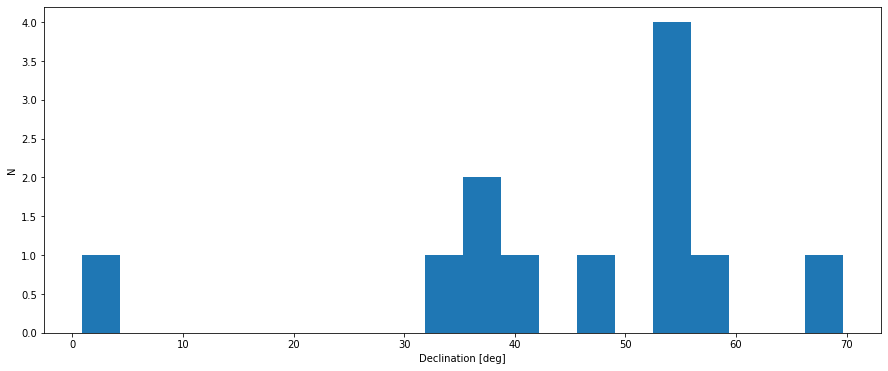

In [72]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(sn_final.loc[mask].meandec, bins=20);
ax.set_xlabel("Declination [deg]")
ax.set_ylabel("N")

Text(0, 0.5, 'N')

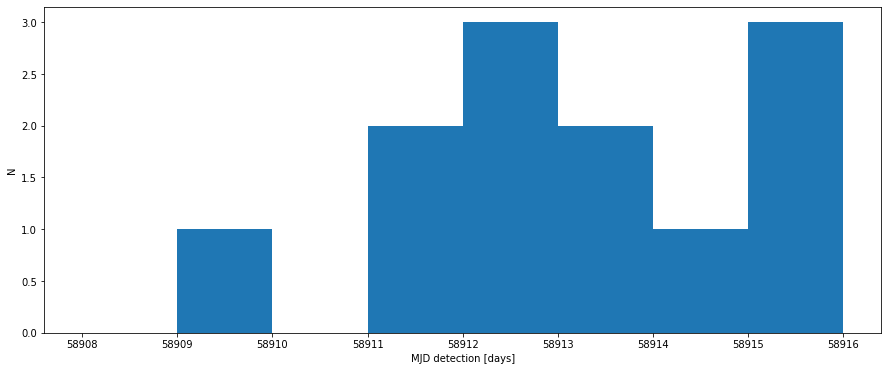

In [73]:
fig, ax = plt.subplots(figsize=(15, 6))
mjd_i = int(sn_final.loc[mask].firstmjd.min() - 1)
mjd_f = int(sn_final.loc[mask].firstmjd.max() + 1)
ax.hist(sn_final.loc[mask].firstmjd, bins=np.linspace(mjd_i, mjd_f, mjd_f - mjd_i + 1));
ax.set_xlabel("MJD detection [days]")
ax.set_ylabel("N")

# Spatial distribution

Text(0, 0.5, 'DEC')

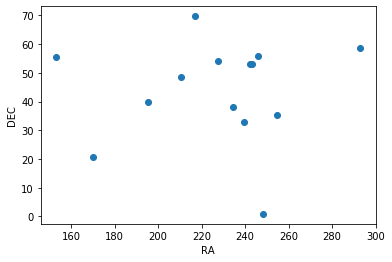

In [74]:
fig, ax = plt.subplots()
ax.scatter(sn_final.meanra,sn_final.meandec)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")

# This is useful if there were lots of candidates to plot

In [71]:
import datashader as ds
import datashader.transfer_functions as tf
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

In [75]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(sn_final.loc[mask], 'meanra', 'meandec', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/datashader/transfer_functions.py:231: RuntimeWarning: invalid value encountered in true_divide
  img = cmap((data - span[0])/(span[1] - span[0]), bytes=True)
/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
